# Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов
### Тариф «Смарт»
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей
### Тариф «Ультра»
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

## Описание данных
Таблица `users` (информация о пользователях):
* *user_id* — уникальный идентификатор пользователя
* *first_name* — имя пользователя
* *last_name* — фамилия пользователя
* *age* — возраст пользователя (годы)
* *reg_date* — дата подключения тарифа (день, месяц, год)
* *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* *city* — город проживания пользователя
* *tariff* — название тарифного плана  
  
Таблица `calls` (информация о звонках):
* *id* — уникальный номер звонка
* *call_date* — дата звонка
* *duration* — длительность звонка в минутах
* *user_id* — идентификатор пользователя, сделавшего звонок  
  
Таблица `messages` (информация о сообщениях):
* *id* — уникальный номер сообщения
* *message_date* — дата сообщения
* *user_id* — идентификатор пользователя, отправившего сообщение  
  
Таблица `internet` (информация об интернет-сессиях):
* *id* — уникальный номер сессии
* *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
* *session_date* — дата интернет-сессии
* *user_id* — идентификатор пользователя  
  
Таблица `tariffs` (информация о тарифах):
* *tariff_name* — название тарифа
* *rub_monthly_fee* — ежемесячная абонентская плата в рублях
* *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
* *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
* *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
* *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv', index_col=0)
messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')
tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')
users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')

## Обзор данных

In [4]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Нужно поменять тип данных в *churn_date* и *reg_date* на datetime

In [6]:
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [7]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Нужно поменять типы данных:
* *call_date* на datetime
* *duration* на int с округлением минут в большую сторону.

В данных вы есть звонки с нулевой продолжительностью (duration = 0.0). Это не ошибка: нулями обозначены пропущенные звонки.

In [8]:
internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [10]:
internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


Тип данных *session_date* поменять на datetime.  
Также нужно убрать сессии с 0-м трафиком.

In [11]:
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [12]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Поменять тип данных *message_date* на datetime

In [13]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Вывод

Необходимо подготовить данные для дальнейшего анализа, а именно:
1. В 'users' нужно поменять тип данных в столбцах *churn_date* и *reg_date* на datetime.
2. В 'calls' нужно поменять типы данных в столбцах:
* *call_date* на datetime
* *duration* на int с округлением минут в большую сторону.
3. В 'internet' тип данных столбца *session_date* поменять на datetime. Также нужно убрать сессии с 0-м трафиком.
4. Поменять в 'messages' тип данных *message_date* на datetime

Для каждого пользователя посчиатем:
1. количество сделанных звонков и израсходованных минут разговора по месяцам;
2. количество отправленных сообщений по месяцам;
3. объем израсходованного интернет-трафика по месяцам;
4. помесячную выручку с каждого пользователя.

## Подготовка данных

In [14]:
users.churn_date = pd.to_datetime(users.churn_date, format='%Y-%m-%d')
users.reg_date = pd.to_datetime(users.reg_date, format='%Y-%m-%d')

In [15]:
calls.call_date = pd.to_datetime(calls.call_date)
messages.message_date = pd.to_datetime(messages.message_date)
internet.session_date = pd.to_datetime(internet.session_date)

In [16]:
internet[internet.mb_used == 0].count()

id              19598
mb_used         19598
session_date    19598
user_id         19598
dtype: int64

In [17]:
internet = internet[internet.mb_used != 0]

In [18]:
calls['month'] = calls.call_date.astype('datetime64[M]')
internet['month'] = internet.session_date.astype('datetime64[M]')
messages['month'] = messages.message_date.astype('datetime64[M]')

In [19]:
calls.duration = (np.ceil(calls.duration)).astype('int')

In [20]:
calls_per_month = calls.pivot_table(index = ['user_id', 'month'], values = 'duration', aggfunc='sum').reset_index().rename(columns={'duration': 'minutes'})
calls_per_month

,user_id,month,minutes
0,1000,2018-05-01,159
1,1000,2018-06-01,172
2,1000,2018-07-01,340
3,1000,2018-08-01,408
4,1000,2018-09-01,466
...,...,...,...
3169,1498,2018-10-01,247
3170,1499,2018-09-01,70
3171,1499,2018-10-01,449
3172,1499,2018-11-01,612


In [21]:
gb_per_month = np.ceil(internet.groupby(['user_id', 'month'])['mb_used'].sum() / 1024).astype('int').reset_index().rename(columns={'mb_used': 'gb'})
gb_per_month

,user_id,month,gb
0,1000,2018-05-01,3
1,1000,2018-06-01,23
2,1000,2018-07-01,14
3,1000,2018-08-01,14
4,1000,2018-09-01,15
...,...,...,...
3196,1498,2018-10-01,21
3197,1499,2018-09-01,2
3198,1499,2018-10-01,18
3199,1499,2018-11-01,18


In [22]:
mes_per_month = messages.groupby(['user_id', 'month'])['id'].count().reset_index().rename(columns={'id':'messages'})
mes_per_month

,user_id,month,messages
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57
...,...,...,...
2712,1498,2018-10-01,42
2713,1499,2018-09-01,11
2714,1499,2018-10-01,48
2715,1499,2018-11-01,59


In [23]:
user_per_month = (calls_per_month
 .merge(gb_per_month, on=['user_id', 'month'], how='outer')
 .merge(mes_per_month, on=['user_id', 'month'], how='outer')
 .merge(users[['user_id', 'tariff']], on='user_id', how='outer')
 )
user_per_month

,user_id,month,minutes,gb,messages,tariff
0,1000,2018-05-01,159.0,3.0,22.0,ultra
1,1000,2018-06-01,172.0,23.0,60.0,ultra
2,1000,2018-07-01,340.0,14.0,75.0,ultra
3,1000,2018-08-01,408.0,14.0,81.0,ultra
4,1000,2018-09-01,466.0,15.0,57.0,ultra
...,...,...,...,...,...,...
3211,1489,2018-10-01,NaN,20.0,21.0,smart
3212,1489,2018-11-01,NaN,18.0,20.0,smart
3213,1489,2018-12-01,NaN,17.0,35.0,smart
3214,1128,NaT,NaN,NaN,NaN,ultra


In [24]:
user_per_month[user_per_month.month.isna()]

,user_id,month,minutes,gb,messages,tariff
3214,1128,NaT,NaN,NaN,NaN,ultra
3215,1371,NaT,NaN,NaN,NaN,smart


In [25]:
user_per_month.dropna(subset=['month'], inplace=True)

In [26]:
user_per_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   3214 non-null   int64         
 1   month     3214 non-null   datetime64[ns]
 2   minutes   3174 non-null   float64       
 3   gb        3201 non-null   float64       
 4   messages  2717 non-null   float64       
 5   tariff    3214 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 175.8+ KB


Функция для подсчета выручки с каждого пользователя.

In [27]:
def give_me_your_money(row):
    tariff = row.tariff
    mp = 0
    minutes = 0
    gbs = 0
    mes = 0
    minute_cost = 0
    mes_cost = 0
    gb_cost = 0
    
    if tariff == 'smart':
        mp = 550
        minutes = 500
        gbs = 15
        mes = 50
        minute_cost = 3
        mes_cost = 3
        gb_cost = 200
        
    elif tariff == 'ultra':
        mp = 1950
        minutes = 3000
        gbs = 30
        mes = 1000
        minute_cost = 1
        mes_cost = 1
        gb_cost = 150
        
    money_minutes = 0 if (row.minutes - minutes) <= 0 else (row.minutes - minutes) * minute_cost
    money_internet = 0 if (row.gb - gbs) <= 0 else (row.gb - gbs) * gb_cost
    money_mes = 0 if (row.messages - mes) <= 0 else (row.messages - mes) * mes_cost
    
    money = money_minutes + money_internet + money_mes + mp
    return money

In [28]:
user_per_month['money'] = user_per_month.fillna(0).apply(give_me_your_money, axis=1)
user_per_month

,user_id,month,minutes,gb,messages,tariff,money
0,1000,2018-05-01,159.0,3.0,22.0,ultra,1950.0
1,1000,2018-06-01,172.0,23.0,60.0,ultra,1950.0
2,1000,2018-07-01,340.0,14.0,75.0,ultra,1950.0
3,1000,2018-08-01,408.0,14.0,81.0,ultra,1950.0
4,1000,2018-09-01,466.0,15.0,57.0,ultra,1950.0
...,...,...,...,...,...,...,...
3209,1489,2018-08-01,NaN,11.0,17.0,smart,550.0
3210,1489,2018-09-01,NaN,17.0,32.0,smart,950.0
3211,1489,2018-10-01,NaN,20.0,21.0,smart,1550.0
3212,1489,2018-11-01,NaN,18.0,20.0,smart,1150.0


## Анализ данных

Рассмотрим сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

In [29]:
users_ultra = user_per_month[user_per_month.tariff=='ultra']
users_smart = user_per_month[user_per_month.tariff=='smart']

In [30]:
def hist_maker_and_table(df, name, in_smart, in_ultra):
    cd = df.groupby(df.tariff)[name]
    cd_desc = cd.describe()
    cd_desc['var']= [np.var(cd.get_group('smart'), ddof=1), np.var(cd.get_group('ultra'), ddof=1)]
    display(cd_desc)
    smart = users_smart[name]
    ultra = users_ultra[name]
    plt.figure(figsize=(10,6))
    plt.hist(smart, bins=50, color='blue', edgecolor='grey', alpha=0.5, label = 'smart', density = False)
    plt.hist(ultra, bins=50, color='orange', edgecolor='grey', alpha=0.5,label = 'ultra', density = False)
    plt.axvline(cd_desc['mean'][0], color='blue', linestyle='dashed', linewidth=3, label=f'Mean smart: {cd_desc["mean"][0]:.2f}')
    
    plt.axvline(cd_desc['mean'][1], color='orange', linestyle='dashed', linewidth=3, label=f'Mean ultra: {cd_desc["mean"][1]:.2f}')

    plt.axvline(in_smart, color='blue', linestyle='solid', linewidth=3, label='Included in tariff smart')
    plt.axvline(in_ultra, color='orange', linestyle='solid', linewidth=3, label='Included in tariff ultra')
    plt.legend()
    plt.title('Histogramm {}'.format(name))

<AxesSubplot:>

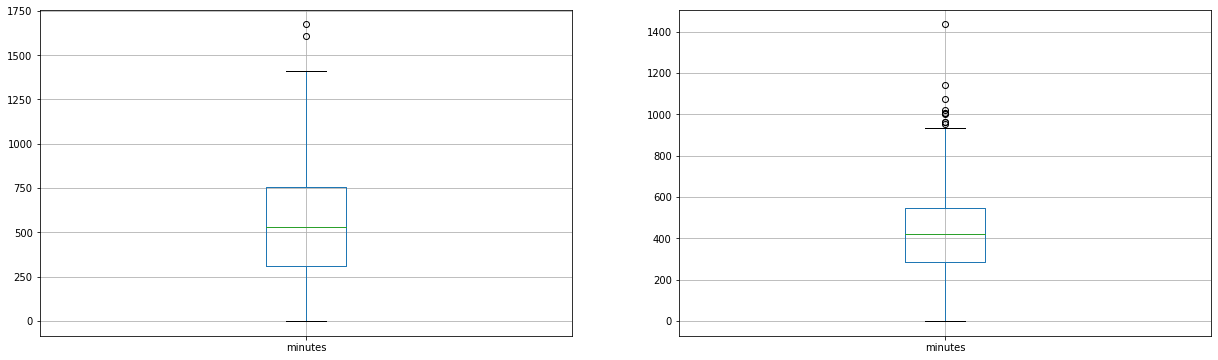

In [31]:
plt.figure(figsize=(21,6))
users_smart.boxplot('minutes', ax = plt.subplot(1, 2, 2))
users_ultra.boxplot('minutes', ax = plt.subplot(1, 2, 1))

,count,mean,std,min,25%,50%,75%,max,var
tariff,,,,,,,,,
smart,2223.0,419.062978,189.325618,0.0,285.0,423.0,545.5,1435.0,35844.189551
ultra,951.0,545.451104,306.925754,0.0,310.0,528.0,756.5,1673.0,94203.418396


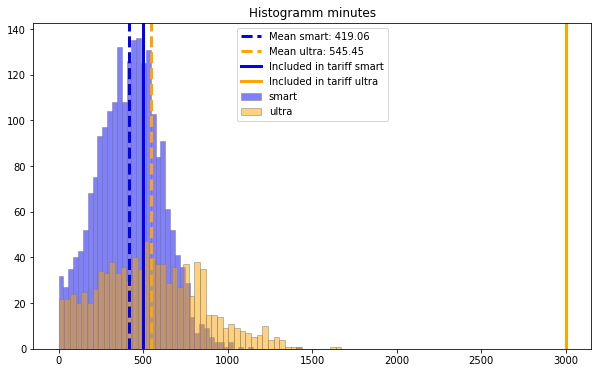

In [32]:
hist_maker_and_table(user_per_month,'minutes',500,3000)

- Пользователи тарифа Смарт в среднем в месяц тратят меньше минут разговора, чем пользователи тарифа Ультра.
- На тарифе Смарт пользователи часто не укладываются в лимиты и доплачивают за звонки. А пользователи тарифа ультра всегда укладываются в установленный лимит минут, максимальное число минут разговора в месяц значительно меньше заложенных в него 3000.

<AxesSubplot:>

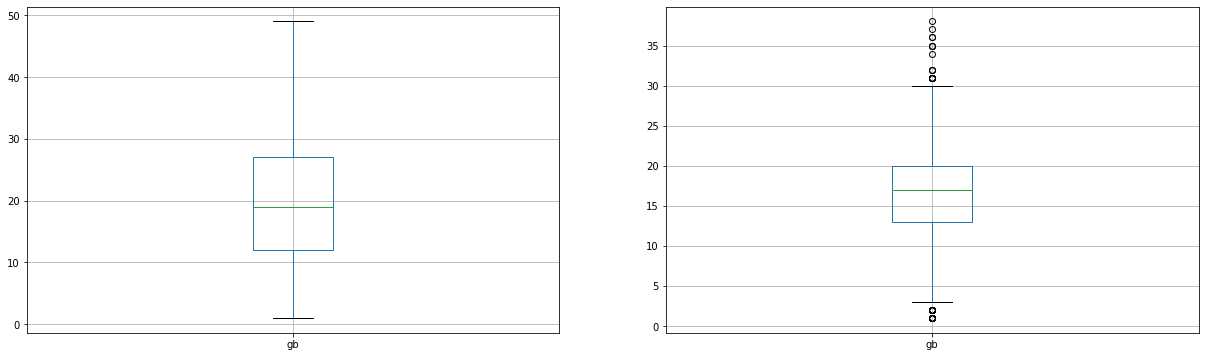

In [33]:
plt.figure(figsize=(21,6))
users_smart.boxplot('gb', ax = plt.subplot(1, 2, 2))
users_ultra.boxplot('gb', ax = plt.subplot(1, 2, 1))

,count,mean,std,min,25%,50%,75%,max,var
tariff,,,,,,,,,
smart,2227.0,16.343511,5.728752,1.0,13.0,17.0,20.0,38.0,32.818605
ultra,974.0,19.714579,9.687335,1.0,12.0,19.0,27.0,49.0,93.844453


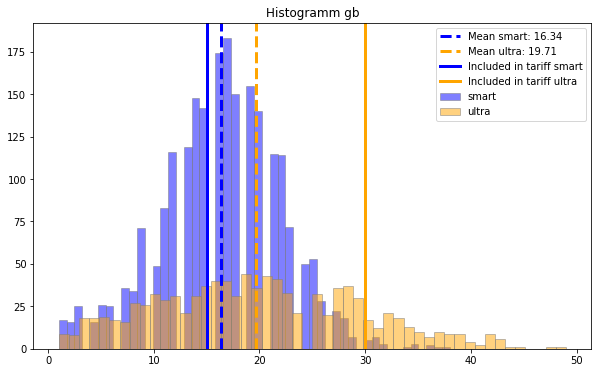

In [34]:
hist_maker_and_table(user_per_month,'gb',15,30)

In [35]:
np.ceil(100 * users_ultra.query('gb > 30')['user_id'].count() / users_ultra.user_id.count())

14.0

- Больше половины пользователей тарифа смарт не укладываются в установленные лимиты по интернет-трафику. В тарифе ультра 14% пользователей тратит больше трафика.
- В среднем пользователи тарифа ультра тратят больше интерент-тарфика.

<AxesSubplot:>

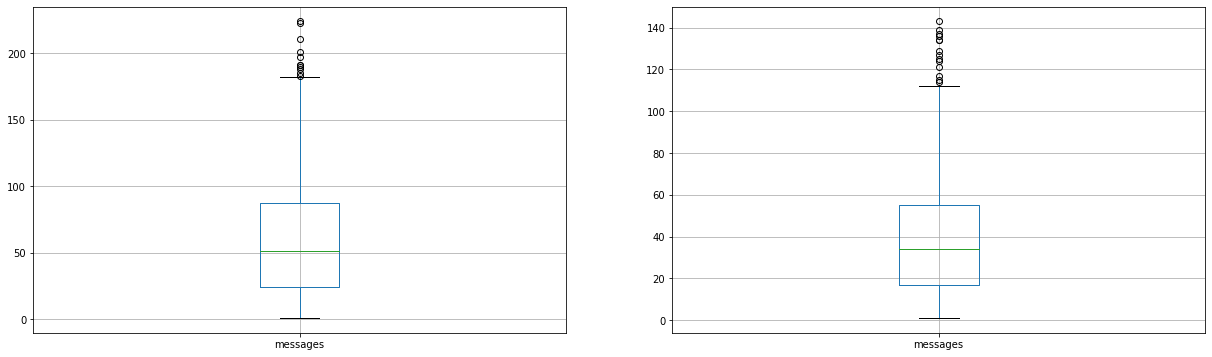

In [36]:
plt.figure(figsize=(21,6))
users_smart.boxplot('messages', ax = plt.subplot(1, 2, 2))
users_ultra.boxplot('messages', ax = plt.subplot(1, 2, 1))

Так как максимаьное количество отправленных сообщений у пользователей тарифа ультра 224, передадим нашей функции параметр включенных сообщений 300. Так гистограмма будет нагляднее.

,count,mean,std,min,25%,50%,75%,max,var
tariff,,,,,,,,,
smart,1922.0,38.716441,26.787949,1.0,17.0,34.0,55.0,143.0,717.594201
ultra,795.0,61.161006,45.931026,1.0,24.0,51.0,87.5,224.0,2109.659183


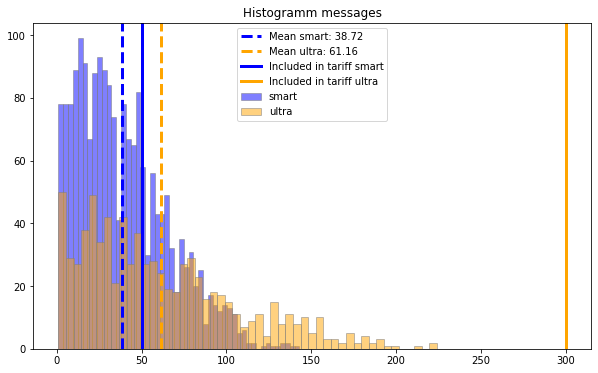

In [37]:
hist_maker_and_table(user_per_month,'messages',50,300)

- В среднем пользователи тарифа ультра отправляют больше сообщений.
- Значительная часть пользователей тарифа смарт не укладывается в лимиты. При этом пользователи тарифа ультра отправляют значительно меньшее количество мообщений, чем им выделено на тарифе.

In [38]:
user_per_month.pivot_table(index='tariff', values=['minutes', 'gb', 'messages'], aggfunc=['mean', 'var', 'std'])

mean                               var               \
               gb   messages     minutes         gb     messages   
tariff                                                             
smart   16.343511  38.716441  419.062978  32.818605   717.594201   
ultra   19.714579  61.161006  545.451104  93.844453  2109.659183   

                           std                         
             minutes        gb   messages     minutes  
tariff                                                 
smart   35844.189551  5.728752  26.787949  189.325618  
ultra   94203.418396  9.687335  45.931026  306.925754

In [39]:
user_per_month.sort_values(by='money', ascending=False).head(15)

,user_id,month,minutes,gb,messages,tariff,money
3108,1486,2018-12-01,1007.0,38.0,83.0,smart,6770.0
260,1042,2018-12-01,728.0,37.0,75.0,smart,5709.0
3107,1486,2018-11-01,764.0,36.0,96.0,smart,5680.0
1622,1261,2018-12-01,1074.0,32.0,22.0,smart,5672.0
1793,1286,2018-12-01,739.0,35.0,68.0,smart,5321.0
1000,1159,2018-12-01,734.0,35.0,2.0,smart,5252.0
615,1098,2018-12-01,588.0,36.0,14.0,smart,5014.0
782,1124,2018-10-01,1225.0,49.0,121.0,ultra,4800.0
1621,1261,2018-11-01,738.0,32.0,25.0,smart,4664.0
1499,1240,2018-08-01,457.0,48.0,NaN,ultra,4650.0


In [40]:
users_smart.money.describe()

count    2229.000000
mean     1289.973531
std       818.404367
min       550.000000
25%       550.000000
50%      1023.000000
75%      1750.000000
max      6770.000000
Name: money, dtype: float64

In [41]:
users_ultra.money.describe()

count     985.000000
mean     2070.152284
std       376.187114
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: money, dtype: float64

Пользовтели тарифа ультра в среднем используют больше минут, сообщений и интрнет-трафика.
Пользователям же тарифа смарт постоянно не достаточно установленных лимитов, большая часть доплачивает за дополнительные минуты, сообщения и гигабайты.

## Проверка гипотез

In [42]:
np.var(users_ultra.money)

141373.07325620347

In [43]:
np.var(users_smart.money)

669485.2209234245

In [44]:
alpha = .05

### Гипотеза 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
Н0: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны.  
Н1: средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны.

In [45]:
res1 = st.ttest_ind(users_ultra.money, users_smart.money, equal_var=False)

In [46]:
print(f'pvalue: {res1.pvalue}')
if res1.pvalue < alpha: 
    print('Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются')
else: print('Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны.')

pvalue: 4.2606313931076085e-250
Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются


p-значение достаточно мало, что дает основание отвергнуть предположение об отсутствии различий между выручками у разных тарифных планов, т.е. маловероятна случайность результатов теста гипотезы.

### Гипотеза 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
Н0: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.  
Н1: средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов.

In [47]:
user_per_month = user_per_month.merge(users[['user_id', 'city']], on='user_id', how='left')
user_per_month

,user_id,month,minutes,gb,messages,tariff,money,city
0,1000,2018-05-01,159.0,3.0,22.0,ultra,1950.0,Краснодар
1,1000,2018-06-01,172.0,23.0,60.0,ultra,1950.0,Краснодар
2,1000,2018-07-01,340.0,14.0,75.0,ultra,1950.0,Краснодар
3,1000,2018-08-01,408.0,14.0,81.0,ultra,1950.0,Краснодар
4,1000,2018-09-01,466.0,15.0,57.0,ultra,1950.0,Краснодар
...,...,...,...,...,...,...,...,...
3209,1489,2018-08-01,NaN,11.0,17.0,smart,550.0,Санкт-Петербург
3210,1489,2018-09-01,NaN,17.0,32.0,smart,950.0,Санкт-Петербург
3211,1489,2018-10-01,NaN,20.0,21.0,smart,1550.0,Санкт-Петербург
3212,1489,2018-11-01,NaN,18.0,20.0,smart,1150.0,Санкт-Петербург


In [48]:
user_msc = user_per_month[user_per_month.city == 'Москва']
user_other = user_per_month[user_per_month.city != 'Москва']

In [49]:
np.var(user_msc.money) 

564710.7117467273

In [50]:
np.var(user_other.money)

653886.3270894174

In [51]:
res2 = st.ttest_ind(user_msc.money, user_other.money)

In [52]:
print(f'pvalue: {res2.pvalue}')
if res2.pvalue < alpha:
    print('Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.')
else:
    print('Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов')

pvalue: 0.5440152911670224
Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов


p-значение достаточно большое, что не дает оснований отвергнуть предположение о различии средней выручки пользователей из Москвы от вырчуки в других регионах, т.е. маловероятна случайность результатов теста гипотезы.

## Общий вывод

Большая часть пользователей тарифа смарт не укладывается в установленные лимиты. Выручка от пользователей этого тарифа доходит до 6750.
Пользователи же тарифа ультра в основном укладываются, лишь 14% пользователям недостаточно выделенного интернет-трафика.  

Выдвинув гипотезы и проверив их мы пришли к выводу, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются, а средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

Средняя выручка от пользователей тарифа "Ультра" больше.  
Соотвественно этот тариф выгоднее для оператора и следует уделить ему больше внимания при составлении рекламного бюджета.